# TODO

* Set all S3 paths to the same directory for ease of search
* Ensure same function used each time we write to/read from S3
* Add descriptions of some [Built-in Rules Provided by Amazon](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html)
* Walk users through the [Training Jobs](https://us-east-2.console.aws.amazon.com/sagemaker/home?region=us-east-2#/jobs) console view after training the sklearn model
* Walk users through cloudwatch metrics after xgboost model
* Walk users through the experiment trials after the tensorflow, torch models
* Add a TOC

# Day 1: SageMaker Training

# 1. SageMaker Architecture Overview

Lets change into the day-1 directory and create a S3 prefix to use for the notebook.

In [7]:
%cd /root/sagemaker-workshop-420/day_1/

BUCKET = 'sagemaker-workshop-420'
PREFIX = 'day-1'

LOCAL_DATA_DIRECTORY = './data/'

/root/sagemaker-workshop-420/day_1


# 2. Train a scikit-learn model using custom training script.

* Introduce the `Estimator` sdk.
* [Example nb](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker-python-sdk/scikit_learn_iris)

In [12]:
import os

import boto3
import numpy as np
import sagemaker
from sagemaker import get_execution_role
from sklearn import datasets

First, lets create our Sagemaker session and role.

In [13]:
boto_session = boto3.Session()
sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()
print(role)

arn:aws:iam::209970524256:role/service-role/AmazonSageMaker-ExecutionRole-20200402T065938


## Upload the data for training <a class="anchor" id="upload_data"></a>

When training large models with huge amounts of data, you'll typically use big data tools, like Amazon Athena, AWS Glue, or Amazon EMR, to create your data in S3. For the purposes of this example, we're using a sample of the classic [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), which is included with Scikit-learn. We will load the dataset, write locally, then write the dataset to s3 to use.

In [8]:
# Load Iris dataset, then join labels and features
iris = datasets.load_iris()
joined_iris = np.insert(iris.data, 0, iris.target, axis=1)

# Create directory and write csv
os.makedirs(LOCAL_DATA_DIRECTORY, exist_ok=True)
np.savetxt(LOCAL_DATA_DIRECTORY + 'iris.csv', joined_iris, delimiter=',',
           fmt='%1.1f, %1.3f, %1.3f, %1.3f, %1.3f')

Once we have the data locally, we can use use the tools provided by the SageMaker Python SDK to upload the data to a default bucket. 

In [17]:
sagemaker_session.default_bucket()

'sagemaker-us-east-2-209970524256'

In [14]:
try:
    if boto_session.region_name == "us-east-1":
        boto_session.client('s3').create_bucket(Bucket=BUCKET)
    else:
        boto_session.client('s3').create_bucket(
            Bucket=BUCKET,
            CreateBucketConfiguration={'LocationConstraint': boto_session.region_name})
except Exception as e:
    print(e)

In [18]:
train_input = sagemaker_session.upload_data(
    LOCAL_DATA_DIRECTORY,
    bucket=BUCKET,
    key_prefix="{}".format(PREFIX))

## Create a Scikit-learn script to train with <a class="anchor" id="create_sklearn_script"></a>
SageMaker can now run a scikit-learn script using the `SKLearn` estimator. When executed on SageMaker a number of helpful environment variables are available to access properties of the training environment, such as:

* `SM_MODEL_DIR`: A string representing the path to the directory to write model artifacts to. Any artifacts saved in this folder are uploaded to S3 for model hosting after the training job completes.
* `SM_OUTPUT_DIR`: A string representing the filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed and uploaded to S3 to the same S3 prefix as the model artifacts.

Supposing two input channels, 'train' and 'test', were used in the call to the `SKLearn` estimator's `fit()` method, the following environment variables will be set, following the format `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAIN`: A string representing the path to the directory containing data in the 'train' channel
* `SM_CHANNEL_TEST`: Same as above, but for the 'test' channel.

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an `argparse.ArgumentParser` instance. For example, the script that we will run in this notebook is the below:

In [19]:
!pygmentize 'sklearn_iris.py'

#  Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#  
#  Licensed under the Apache License, Version 2.0 (the "License").
#  You may not use this file except in compliance with the License.
#  A copy of the License is located at
#  
#      http://www.apache.org/licenses/LICENSE-2.0
#  
#  or in the "license" file accompanying this file. This file is distributed 
#  on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either 
#  express or implied. See the License for the specific language governing 
#  permissions and limitations under the License.

from __future__ import print_function

import argparse
import os
import pandas as pd

from sklearn import tree
from sklearn.externals import joblib


if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters are described here. In this simple example we are just including one hyperparameter.
    parser.add_argument('--max_leaf_nodes', type=int, default=-1)

    # Sagemaker

Because the Scikit-learn container imports your training script, you should always put your training code in a main guard `(if __name__=='__main__':)` so that the container does not inadvertently run your training code at the wrong point in execution.

For more information about training environment variables, please visit https://github.com/aws/sagemaker-containers.

## Create SageMaker Scikit Estimator <a class="anchor" id="create_sklearn_estimator"></a>

To run our Scikit-learn training script on SageMaker, we construct a `sagemaker.sklearn.estimator.sklearn` estimator, which accepts several constructor arguments:

* __entry_point__: The path to the Python script SageMaker runs for training and prediction.
* __role__: Role ARN
* __train_instance_type__ *(optional)*: The type of SageMaker instances for training. __Note__: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* __sagemaker_session__ *(optional)*: The session used to train on Sagemaker.
* __hyperparameters__ *(optional)*: A dictionary passed to the train function as hyperparameters.

To see the code for the SKLearn Estimator, see here: https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/sklearn

In [20]:
from sagemaker.sklearn.estimator import SKLearn

script_path = 'sklearn_iris.py'

sklearn = SKLearn(
    entry_point=script_path,
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={'max_leaf_nodes': 30})

## Train SKLearn Estimator on Iris data <a class="anchor" id="train_sklearn"></a>
Training is very simple, just call `fit` on the Estimator! This will start a SageMaker Training job that will download the data for us, invoke our scikit-learn code (in the provided script file), and save any model artifacts that the script creates.

In [22]:
sklearn.fit({'train': train_input})

2020-04-05 11:55:23 Starting - Starting the training job...
2020-04-05 11:55:24 Starting - Launching requested ML instances......
2020-04-05 11:56:24 Starting - Preparing the instances for training...
2020-04-05 11:57:05 Downloading - Downloading input data...
2020-04-05 11:57:47 Training - Training image download completed. Training in progress.
2020-04-05 11:57:47 Uploading - Uploading generated training model2020-04-05 11:57:43,101 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-04-05 11:57:43,103 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-05 11:57:43,113 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-04-05 11:57:43,380 sagemaker-containers INFO     Module sklearn_iris does not provide a setup.py. 
Generating setup.py
2020-04-05 11:57:43,380 sagemaker-containers INFO     Generating setup.cfg
2020-04-05 11:57:43,380 sagemaker-containers INFO     Generating MANIFEST.

# 3. Debug training using Debugger.

* Train an XGBoost model.
* Debug using Rules.
    * Discuss the built-in rules available.

# Debugging XGBoost Training Jobs with Amazon SageMaker Debugger Using Rules

This notebook was created and tested on an ml.m5.4xlarge notebook instance.

## Overview

Amazon SageMaker Debugger is a new capability of Amazon SageMaker that allows debugging machine learning training. 
Amazon SageMaker Debugger helps you to monitor your training in near real time using rules and would provide you alerts, once it has detected inconsistency in training. 

Using Amazon SageMaker Debugger is a two step process: Saving tensors and Analysis.
Let's look at each one of them closely.

### Saving tensors

In deep learning algorithms, tensors define the state of the training job at any particular instant in its lifecycle.
Amazon SageMaker Debugger exposes a library which allows you to capture these tensors and save them for analysis.
Although XGBoost is not a deep learning algorithm, Amazon SageMaker Debugger is highly customizable and can help provide interpretability by saving insightful metrics, such as performance metrics or feature importances, at different frequencies.
Refer to [documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/xgboost.md) for details on how to save the metrics you want.


### Analysis

After the tensors are saved, perform automatic analysis by running debugging ***Rules***.
On a very broad level, a rule is Python code used to detect certain conditions during training.
Some of the conditions that a data scientist training an algorithm may care about are monitoring for gradients getting too large or too small, detecting overfitting, and so on.
Amazon SageMaker Debugger comes pre-packaged with certain rules that can be invoked on Amazon SageMaker. Users can also write their own rules using the Amazon SageMaker Debugger APIs. 
For more information about automatic analysis using a rule, see the [rules documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md).

In [26]:
import sys

In [27]:
!{sys.executable} -m pip install smdebug

In [29]:
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri

Amazon SageMaker Debugger is available in Amazon SageMaker XGBoost container version 0.90-2 or later. If you want to use XGBoost with Amazon SageMaker Debugger, you have to specify `repo_version='0.90-2'` in the `get_image_uri` function.

In [31]:
boto_session = boto3.Session()
sagemaker_session = sagemaker.Session()

region = boto_session.region_name

container = get_image_uri(region, "xgboost", repo_version="0.90-2")
print(container)

257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3


## Training XGBoost models in Amazon SageMaker with Amazon SageMaker Debugger

Now train an XGBoost model with Amazon SageMaker Debugger enabled and monitor the training jobs. This is done using the Amazon SageMaker Estimator API. While the training job is running, use Amazon SageMaker Debugger API to access saved tensors in real time and visualize them. You can rely on Amazon SageMaker Debugger to take care of downloading a fresh set of tensors every time you query for them.

This example is adapted from [XGBoost for Regression](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/xgboost_abalone). Refer to [XGBoost for Regression](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/xgboost_abalone) for an example of using classification from Amazon SageMaker's implementation of [XGBoost](https://github.com/dmlc/xgboost).

### Data preparation

Use the [Abalone data](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html) originally from the [UCI data repository](https://archive.ics.uci.edu/ml/datasets/abalone).
More details about the original dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names).
In the libsvm converted [version](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html), the nominal feature (Male/Female/Infant) has been converted into a real valued feature.
Age of abalone is to be predicted from eight physical measurements.

Following methods download the Abalone data, split the data into training and validation
sets, and upload files to Amazon Simple Storage Service (Amazon S3).

In [9]:
from data_utils import load_abalone, upload_to_s3

bucket = sagemaker.Session().default_bucket()
prefix = "DEMO-smdebug-xgboost-abalone"

In [10]:
%%time

train_file, validation_file = load_abalone()
upload_to_s3(train_file, bucket, f"{prefix}/train/abalone.train.libsvm")
upload_to_s3(validation_file, bucket, f"{prefix}/validation/abalone.validation.libsvm")

Writing to s3://sagemaker-us-east-2-209970524256/DEMO-smdebug-xgboost-abalone/train/abalone.train.libsvm
Writing to s3://sagemaker-us-east-2-209970524256/DEMO-smdebug-xgboost-abalone/validation/abalone.validation.libsvm
CPU times: user 125 ms, sys: 29.5 ms, total: 155 ms
Wall time: 2.3 s


In [22]:
from sagemaker import get_execution_role

role = get_execution_role()
base_job_name = "demo-smdebug-xgboost-classification"
bucket_path = 's3://{}'.format(bucket)

hyperparameters={
    "max_depth": "5",
    #"eta": "0.2",
    "eta": "1.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "silent": "0",
    "objective": "reg:squarederror",
    "num_round": "51",
}

save_interval = 5

base_job_name = "demo-smdebug-xgboost-regression"

### Enabling Debugger in Estimator object


#### DebuggerHookConfig

Enabling Amazon SageMaker Debugger in training job can be accomplished by adding its configuration into Estimator object constructor:

```python
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

estimator = Estimator(
    ...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "10"
                }
            )
        ]
    )
)
```
Here, the `DebuggerHookConfig` object instructs `Estimator` what data we are interested in.
Two parameters are provided in the example:

- `s3_output_path`: it points to S3 bucket/path where we intend to store our debugging tensors.
  Amount of data saved depends on multiple factors, major ones are: training job / data set / model / frequency of saving tensors.
  This bucket should be in your AWS account, and you should have full access control over it.
  **Important Note**: this s3 bucket should be originally created in the same region where your training job will be running, otherwise you might run into problems with cross region access.

- `collection_configs`: it enumerates named collections of tensors we want to save.
  Collections are a convinient way to organize relevant tensors under same umbrella to make it easy to navigate them during analysis.
  In this particular example, you are instructing Amazon SageMaker Debugger that you are interested in a single collection named `metrics`.
  We also instructed Amazon SageMaker Debugger to save metrics every 10 iteration.
  See [Collection](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#collection) documentation for all parameters that are supported by Collections and DebuggerConfig documentation for more details about all parameters DebuggerConfig supports.
  
#### Rules

Enabling Rules in training job can be accomplished by adding the `rules` configuration into Estimator object constructor.

- `rules`: This new parameter will accept a list of rules you wish to evaluate against the tensors output by this training job.
  For rules, Amazon SageMaker Debugger supports two types:
  - SageMaker Rules: These are rules specially curated by the data science and engineering teams in Amazon SageMaker which you can opt to evaluate against your training job.
  - Custom Rules: You can optionally choose to write your own rule as a Python source file and have it evaluated against your training job.
    To provide Amazon SageMaker Debugger to evaluate this rule, you would have to provide the S3 location of the rule source and the evaluator image.

In this example, you will use a Amazon SageMaker's LossNotDecreasing rule, which helps you identify if you are running into a situation where the training loss is not going down.

```python
from sagemaker.debugger import rule_configs, Rule

estimator = Estimator(
    ...,
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ],
)
```

- `rule_parameters`: In this parameter, you provide the runtime values of the parameter in your constructor.
  You can still choose to pass in other values which may be necessary for your rule to be evaluated.
  In this example, you will use Amazon SageMaker's LossNotDecreasing rule to monitor the `metircs` collection.
  The rule will alert you if the tensors in `metrics` has not decreased for more than 10 steps.

In [23]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator

algorithm_mode_default_estimator = Estimator(
    role=role,
    base_job_name=base_job_name,
    train_instance_count=1,
    train_instance_type='ml.m5.xlarge',
    image_name=container,
    hyperparameters=hyperparameters,
    train_max_run=1800,

    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=bucket_path,  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
        ],
    ),

    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
    ],
)

With the next step, start a training job by using the Estimator object you created above. This job is started in an asynchronous, non-blocking way. This means that control is passed back to the notebook and further commands can be run while the training job is progressing.

In [24]:
from sagemaker.session import s3_input

train_s3_input = s3_input("s3://{}/{}/{}".format(bucket, prefix, "train"), content_type="libsvm")
validation_s3_input = s3_input( "s3://{}/{}/{}".format(bucket, prefix, "validation"), content_type="libsvm")
algorithm_mode_default_estimator.fit(
    {"train": train_s3_input, "validation": validation_s3_input},
    # This is a fire and forget event. By setting wait=False, you just submit the job to run in the background.
    # Amazon SageMaker starts one training job and release control to next cells in the notebook.
    # Follow this notebook to see status of the training job.
    wait=False
)

### Result

As a result of the above command, Amazon SageMaker starts one training job and one rule job for you. The first one is the job that produces the tensors to be analyzed. The second one analyzes the tensors to check if `train-rmse` and `validation-rmse` are not decreasing at any point during training.

Check the status of the training job below.
After your training job is started, Amazon SageMaker starts a rule-execution job to run the LossNotDecreasing rule.

**Note that the next cell blocks until the rule execution job ends. You can stop it at any point to proceed to the rest of the notebook. Once it says Rule Evaluation Status is Started, and shows the `RuleEvaluationJobArn`, you can look at the status of the rule being monitored.**

In [25]:
import time

for _ in range(360):
    job_name = algorithm_mode_default_estimator.latest_training_job.name
    client = algorithm_mode_default_estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = algorithm_mode_default_estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print("Training job status: {}, Rule Evaluation Status: {}".format(training_job_status, rule_evaluation_status))

    if rule_evaluation_status in ["Stopped", "IssuesFound", "NoIssuesFound"]:
        break

    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

### Check the status of the Rule Evaluation Job

To get the rule evaluation job that Amazon SageMaker started for you, run the command below. The results show you the `RuleConfigurationName`, `RuleEvaluationJobArn`, `RuleEvaluationStatus`, `StatusDetails`, and `RuleEvaluationJobArn`.
If the tensors meets a rule evaluation condition, the rule execution job throws a client error with `RuleEvaluationConditionMet`.

The logs of the rule evaluation job are available in the Cloudwatch Logstream `/aws/sagemaker/ProcessingJobs` with `RuleEvaluationJobArn`.

You can see that once the rule execution job starts, it identifies the loss not decreasing situation in the training job, it raises the `RuleEvaluationConditionMet` exception, and it ends the job.

In [26]:
algorithm_mode_default_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:209970524256:processing-job/demo-smdebug-xgboost-regre-lossnotdecreasing-2f1c2910',
  'RuleEvaluationStatus': 'Stopped',
  'LastModifiedTime': datetime.datetime(2020, 4, 3, 11, 35, 22, 473000, tzinfo=tzlocal())}]

## Making this a good run

In previous example, you saw how a LossNotDecreasing rule was run that analyzed the tensors when training was running and produced an alert.

You can go back and change the hyperparameters passed to the estimator to `hyperparameters` and start a new training job (e.g., use a smaller learning rate `eta=0.05`). You can see that the LossNotDecreasing rule is not fired in that case as both `train-rmse` and `validation-rmse` keep decreasing steadily throughout the entire training duration.

## Data Analysis - Manual

Now that you've trained the system, analyze the data.
Here, you focus on after-the-fact analysis.

You import a basic analysis library, which defines the concept of trial, which represents a single training run.

In [28]:
s3_output_path

's3://sagemaker-us-east-2-209970524256/demo-smdebug-xgboost-regression-2020-04-03-11-30-25-205/debug-output'

In [27]:
from smdebug.trials import create_trial

s3_output_path = algorithm_mode_default_estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2020-04-03 11:36:05.714 4a9541ccf861:109 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-2-209970524256/demo-smdebug-xgboost-regression-2020-04-03-11-30-25-205/debug-output
[2020-04-03 11:36:26.490 4a9541ccf861:109 WARNING trial.py:148] Waiting to read collections files generated by the training job,from s3://sagemaker-us-east-2-209970524256/demo-smdebug-xgboost-regression-2020-04-03-11-30-25-205/debug-output/. If this has been a while, you might want to check that the trial is pointed at the right path.
[2020-04-03 11:36:28.523 4a9541ccf861:109 WARNING trial.py:148] Waiting to read collections files generated by the training job,from s3://sagemaker-us-east-2-209970524256/demo-smdebug-xgboost-regression-2020-04-03-11-30-25-205/debug-output/. If this has been a while, you might want to check that the trial is pointed at the right path.
[2020-04-03 11:36:30.558 4a9541ccf861:109 WARNING trial.py:148] Waiting to read collections files generated by the traini

KeyboardInterrupt: 

In [29]:
# TODO REMOVE THIS CELL

s3_output_path = 's3://sagemaker-us-east-2-209970524256/demo-smdebug-xgboost-regression-2020-04-03-11-24-18-350/debug-output'
trial = create_trial(s3_output_path)

[2020-04-03 11:39:29.991 4a9541ccf861:109 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-2-209970524256/demo-smdebug-xgboost-regression-2020-04-03-11-24-18-350/debug-output


You can list all the tensors that you know something about. Each one of these names is the name of a tensor. The name is a combination of the feature name, which in these cases, is auto-assigned by XGBoost, and whether it's an evaluation metric, feature importance, or SHAP value.

In [30]:
trial.tensor_names()

[2020-04-03 11:39:34.145 4a9541ccf861:109 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-04-03 11:39:35.163 4a9541ccf861:109 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f2',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 'feature_importance/gain/f8',
 'feature_importance/total_cover/f1',
 'feature_importance/total_cover/f2',
 'feature_importance/total_cover/f3',
 'feature_importance/total_cover/f4',
 'feature_importance/total_cover/f5',
 'feature_importance/total_cover/f6',
 'feature_importance/total_cover/f7',
 'feature_importance/total_cover/f8',
 'feature_im

For each tensor, ask for the steps where you have data. In this case, every five steps

In [31]:
trial.tensor("train-rmse").steps()

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

You can obtain each tensor at each step as a NumPy array.

In [37]:
trial.tensor("train-rmse").values()

{0: array([8.128091]),
 5: array([3.350507]),
 10: array([2.180568]),
 15: array([1.945831]),
 20: array([1.879669]),
 25: array([1.832805]),
 30: array([1.785575]),
 35: array([1.746151]),
 40: array([1.72441]),
 45: array([1.689941]),
 50: array([1.66069])}

In [38]:
trial.tensor("validation-rmse").values()

{0: array([7.950097]),
 5: array([3.287516]),
 10: array([2.217748]),
 15: array([2.051376]),
 20: array([2.034932]),
 25: array([2.046283]),
 30: array([2.052916]),
 35: array([2.047896]),
 40: array([2.054105]),
 45: array([2.050383]),
 50: array([2.057345])}

### Performance metrics

You can also create a simple function that visualizes the training and validation errors as the training progresses.
Each gradient should get smaller over time, as the system converges to a good solution.
Remember that this is an interactive analysis. You are showing these tensors to give an idea of the data.

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import re


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

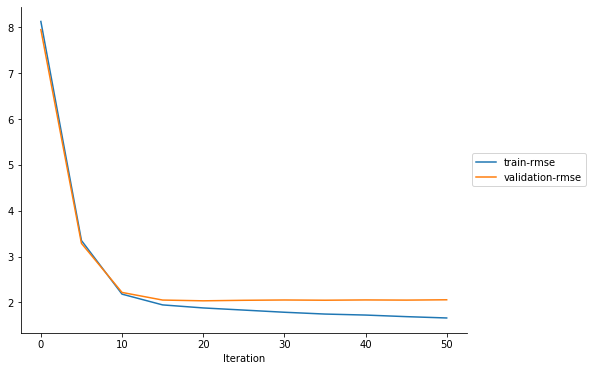

In [40]:
plot_collection(trial, "metrics")

### Feature importances

You can also visualize the feature priorities as determined by
[xgboost.get_score()](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score).
If you instructed Estimator to log the `feature_importance` collection, all five importance types supported by `xgboost.get_score()` will be available in the collection.

In [41]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

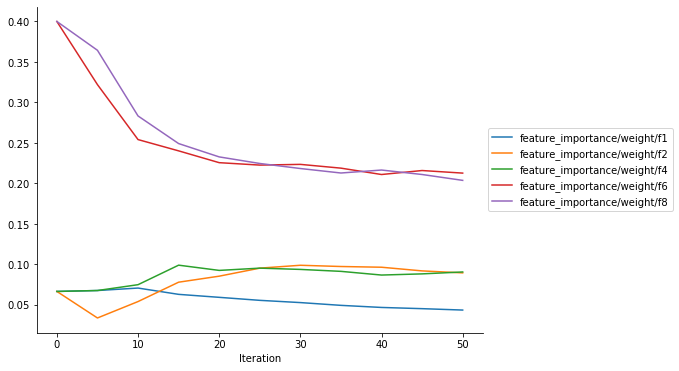

In [42]:
plot_feature_importance(trial)

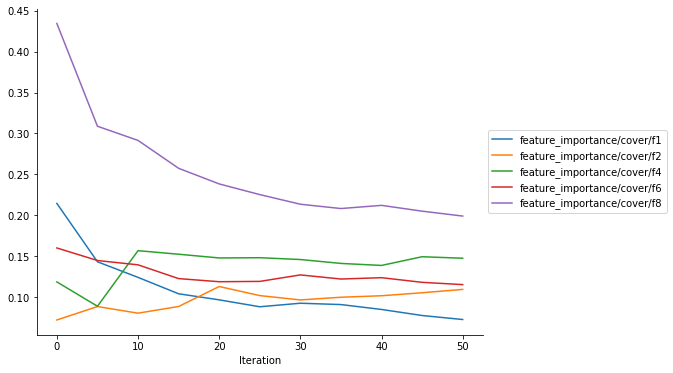

In [43]:
plot_feature_importance(trial, importance_type="cover")

### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is
another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output.
You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by [xgboost.predict(pred_contribs=True)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict)) will be available the `average_shap` collection.

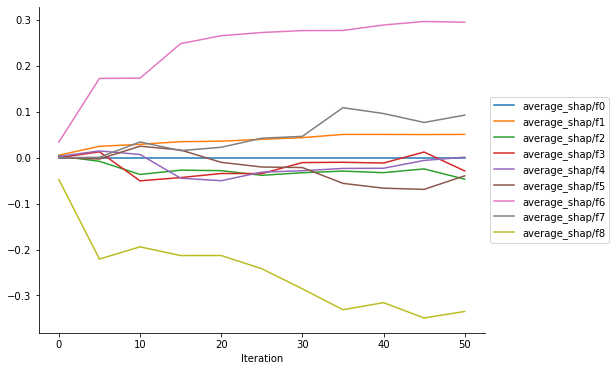

In [44]:
plot_collection(trial,"average_shap")

# 4. Monitor and analyze training jobs using metrics.

* Train a Tensorflow 2.0 model.

# 5. Organize results of experiments with Experiments, Trials, and Search.

* Train a Tensorflow 2.0 model and PyTorch Model.
* [NB](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/tensorflow_script_mode_training_and_serving/tensorflow_script_mode_training_and_serving.ipynb)

# TensorFlow script mode training and serving

Script mode is a training script format for TensorFlow that lets you execute any TensorFlow training script in SageMaker with minimal modification. The [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) handles transferring your script to a SageMaker training instance. On the training instance, SageMaker's native TensorFlow support sets up training-related environment variables and executes your training script. In this tutorial, we use the SageMaker Python SDK to launch a training job and deploy the trained model.

Script mode supports training with a Python script, a Python module, or a shell script. In this example, we use a Python script to train a classification model on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). In this example, we will show how easily you can train a SageMaker using TensorFlow 1.x and TensorFlow 2.0 scripts with SageMaker Python SDK. In addition, this notebook demonstrates how to perform real time inference with the [SageMaker TensorFlow Serving container](https://github.com/aws/sagemaker-tensorflow-serving-container). The TensorFlow Serving container is the default inference method for script mode. For full documentation on the TensorFlow Serving container, please visit [here](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/deploying_tensorflow_serving.rst).


# Set up the environment

Let's start by setting up the environment:

In [2]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

## Training Data

The MNIST dataset has been loaded to the public S3 buckets ``sagemaker-sample-data-<REGION>`` under the prefix ``tensorflow/mnist``. There are four ``.npy`` file under this prefix:
* ``train_data.npy``
* ``eval_data.npy``
* ``train_labels.npy``
* ``eval_labels.npy``

In [5]:
training_data_uri = 's3://sagemaker-sample-data-{}/tensorflow/mnist'.format(region)
training_data_uri

's3://sagemaker-sample-data-us-east-2/tensorflow/mnist'

# Construct a script for distributed training

This tutorial's training script was adapted from TensorFlow's official [CNN MNIST example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/layers/cnn_mnist.py). We have modified it to handle the ``model_dir`` parameter passed in by SageMaker. This is an S3 path which can be used for data sharing during distributed training and checkpointing and/or model persistence. We have also added an argument-parsing function to handle processing training-related variables.

At the end of the training job we have added a step to export the trained model to the path stored in the environment variable ``SM_MODEL_DIR``, which always points to ``/opt/ml/model``. This is critical because SageMaker uploads all the model artifacts in this folder to S3 at end of training.

Here is the entire script:

In [10]:
# TensorFlow 2.1 script
!pygmentize 'tf2-mnist.py'

# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.import tensorflow as tf

import tensorflow as tf
import argparse
import os
import numpy as np
import json


def model(x_train, y_train, x_test, y_test):
    """Generate a simple model"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    mod

# Create a training job using the `TensorFlow` estimator

The `sagemaker.tensorflow.TensorFlow` estimator handles locating the script mode container, uploading your script to a S3 location and creating a SageMaker training job. Let's call out a couple important parameters here:

* `py_version` is set to `'py3'` to indicate that we are using script mode since legacy mode supports only Python 2. Though Python 2 will be deprecated soon, you can use script mode with Python 2 by setting `py_version` to `'py2'` and `script_mode` to `True`.

* `distributions` is used to configure the distributed training setup. It's required only if you are doing distributed training either across a cluster of instances or across multiple GPUs. Here we are using parameter servers as the distributed training schema. SageMaker training jobs run on homogeneous clusters. To make parameter server more performant in the SageMaker setup, we run a parameter server on every instance in the cluster, so there is no need to specify the number of parameter servers to launch. Script mode also supports distributed training with [Horovod](https://github.com/horovod/horovod). You can find the full documentation on how to configure `distributions` [here](https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/tensorflow#distributed-training). 



In [18]:
from sagemaker.tensorflow import TensorFlow


"""mnist_estimator2 = TensorFlow(entry_point='tf2-mnist.py',
                              role=role,
                              train_instance_count=2,
                              train_instance_type='ml.p2.xlarge',
                              framework_version='2.1.0',
                              py_version='py3',
                              distributions={'parameter_server': {'enabled': True}})"""

mnist_estimator2 = TensorFlow(entry_point='tf2-mnist.py',
                              role=role,
                              train_instance_count=1,
                              train_instance_type='ml.p2.xlarge',#"ml.c4.xlarge",
                              framework_version='2.1.0',
                              py_version='py3')

## Calling ``fit``

To start a training job, we call `estimator.fit(training_data_uri)`.

An S3 location is used here as the input. `fit` creates a default channel named `'training'`, which points to this S3 location. In the training script we can then access the training data from the location stored in `SM_CHANNEL_TRAINING`. `fit` accepts a couple other types of input as well. See the API doc [here](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.EstimatorBase.fit) for details.

When training starts, the TensorFlow container executes mnist.py, passing `hyperparameters` and `model_dir` from the estimator as script arguments. Because we didn't define either in this example, no hyperparameters are passed, and `model_dir` defaults to `s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>`, so the script execution is as follows:
```bash
python mnist.py --model_dir s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>
```
When training is complete, the training job will upload the saved model for TensorFlow serving.

In [ ]:
mnist_estimator2.fit(training_data_uri)

2020-04-04 13:22:41 Starting - Starting the training job...
2020-04-04 13:22:42 Starting - Launching requested ML instances...
2020-04-04 13:23:39 Starting - Preparing the instances for training......

### Install Python SDKs

In [24]:
import sys

In [24]:
!{sys.executable} -m pip install sagemaker-experiments
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision

     |████████████████████████████████| 753.4 MB 4.0 kB/s  eta 0:00:01     |███████                         | 164.0 MB 72.5 MB/s eta 0:00:09████████████▏                 | 333.9 MB 74.0 MB/s eta 0:00:06��█████████████▌              | 413.1 MB 72.3 MB/s eta 0:00:05     |████████████████████▎           | 477.2 MB 76.1 MB/s eta 0:00:04��█████████████▊    | 653.3 MB 73.5 MB/s eta 0:00:02ta 0:00:01     |███████████████████████████████▏| 734.9 MB 62.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 2.9 MB/s eta 0:00:01


In [25]:
import time

import boto3
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [26]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = get_execution_role()

### Create a S3 bucket to hold data

In [27]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
bucket = 'sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
prefix = 'mnist'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print(e)

### Dataset
We download the MNIST hand written digits dataset, and then apply transformation on each of the image.

In [28]:
# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_set = datasets.MNIST('mnist', train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]), 
    download=True)
                           
test_set = datasets.MNIST('mnist', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]),
    download=False)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


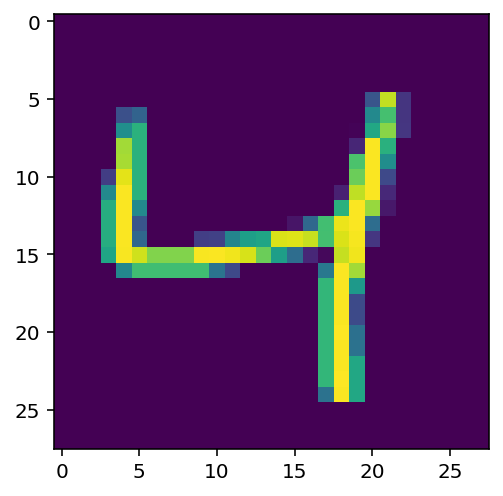

In [30]:
plt.imshow(train_set.data[2].numpy());

After transforming the images in the dataset, we upload it to s3.

In [31]:
inputs = sagemaker.Session().upload_data(path='mnist', bucket=bucket, key_prefix=prefix)
print('input spec: {}'.format(inputs))

input spec: s3://sagemaker-experiments-us-east-2-209970524256/mnist


Now lets track the parameters from the data pre-processing step.

In [32]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "normalization_mean": 0.1307,
        "normalization_std": 0.3081,
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

### Step 1 - Set up the Experiment

Create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work for : [1] a business use case you are addressing (e.g. create experiment named “customer churn prediction”), or [2] a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”), or [3] a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

### Create an Experiment

In [33]:
mnist_experiment = Experiment.create(
    experiment_name=f"mnist-hand-written-digits-classification-{int(time.time())}", 
    description="Classification of mnist hand-written digits", 
    sagemaker_boto_client=sm)
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f2bf6788d10>,experiment_name='mnist-hand-written-digits-classification-1586085592',description='Classification of mnist hand-written digits',experiment_arn='arn:aws:sagemaker:us-east-2:209970524256:experiment/mnist-hand-written-digits-classification-1586085592',response_metadata={'RequestId': '1588c5dd-a8a6-4d3b-9247-0d966655fefa', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '1588c5dd-a8a6-4d3b-9247-0d966655fefa', 'content-type': 'application/x-amz-json-1.1', 'content-length': '123', 'date': 'Sun, 05 Apr 2020 11:19:52 GMT'}, 'RetryAttempts': 0})


### Step 2 - Track Experiment
### Now create a Trial for each training run to track the it's inputs, parameters, and metrics.
While training the CNN model on SageMaker, we will experiment with several values for the number of hidden channel in the model. We will create a Trial to track each training job run. We will also create a TrialComponent from the tracker we created before, and add to the Trial. This will enrich the Trial with the parameters we captured from the data pre-processing stage.

Note the execution of the following code takes a while.

In [34]:
from sagemaker.pytorch import PyTorch

In [35]:
hidden_channel_trial_name_map = {}

If you want to run the following training jobs asynchronously, you may need to increase your resource limit. Otherwise, you can run them sequentially.

In [36]:
preprocessing_trial_component = tracker.trial_component

In [38]:
for i, num_hidden_channel in enumerate([2, 5]): #enumerate([2, 5, 10, 20, 32]):
    # create trial
    trial_name = f"cnn-training-job-{num_hidden_channel}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name
    
    # associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(preprocessing_trial_component)
    
    # all input configurations, parameters, and metrics specified in estimator 
    # definition are automatically tracked
    estimator = PyTorch(
        entry_point='./pytorch_mnist.py',
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version='1.1.0',
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': num_hidden_channel,
            'dropout': 0.2,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
            {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
            {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
        ],
        enable_sagemaker_metrics=True,
    )
    
    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))
    
    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={'training': inputs}, 
        job_name=cnn_training_job_name,
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )
    
    # give it a while before dispatching the next training job
    time.sleep(2)

INFO:sagemaker:Creating training-job with name: cnn-training-job-1586085907


2020-04-05 11:25:08 Starting - Starting the training job...
2020-04-05 11:25:09 Starting - Launching requested ML instances......
2020-04-05 11:26:08 Starting - Preparing the instances for training...
2020-04-05 11:26:49 Downloading - Downloading input data...
2020-04-05 11:27:32 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-05 11:27:34,251 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-05 11:27:34,254 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-05 11:27:34,265 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-05 11:27:34,266 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-05 11:27:34,504 sagemaker-containers INFO     Module pytorch_mnist does not provide a setup.py. 
Generating 

INFO:sagemaker:Creating training-job with name: cnn-training-job-1586086132


2020-04-05 11:28:52 Starting - Starting the training job...
2020-04-05 11:28:54 Starting - Launching requested ML instances...
2020-04-05 11:29:50 Starting - Preparing the instances for training......
2020-04-05 11:30:51 Downloading - Downloading input data...
2020-04-05 11:31:21 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-05 11:31:22,805 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-05 11:31:22,808 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-05 11:31:22,819 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-05 11:31:25,832 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-05 11:31:26,144 sagemaker-containers INFO     Module pytorch_mnist does not provide a setup.py. 
Generating

### Compare the model training runs for an experiment

Now we will use the analytics capabilities of Python SDK to query and compare the training runs for identifying the best model produced by our experiment. You can retrieve trial components by using a search expression.

### Some Simple Analyses

In [39]:
search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [40]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    experiment_name=mnist_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=['test:accuracy'],
    parameter_names=['hidden_channels', 'epochs', 'dropout', 'optimizer']
)

In [41]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,dropout,epochs,hidden_channels,optimizer,test:accuracy - Min,test:accuracy - Max,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count
0,cnn-training-job-1586085907-aws-training-job,Training,arn:aws:sagemaker:us-east-2:209970524256:train...,0.2,2.0,2.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
1,cnn-training-job-1586086132-aws-training-job,Training,arn:aws:sagemaker:us-east-2:209970524256:train...,0.2,2.0,5.0,"""sgd""",94.0,96.0,95.0,1.414214,96.0,2


To isolate and measure the impact of change in hidden channels on model accuracy, we vary the number of hidden channel and fix the value for other hyperparameters.

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for `cnn-training-job-2-hidden-channels` trial

In [42]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": hidden_channel_trial_name_map[2]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [43]:
lineage_table.dataframe()

,TrialComponentName,DisplayName,normalization_mean,normalization_std,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,backend,...,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count,train:loss - Min,train:loss - Max,train:loss - Avg,train:loss - StdDev,train:loss - Last,train:loss - Count
0,TrialComponent-2020-04-05-111924-xmeh,Preprocessing,0.1307,0.3081,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cnn-training-job-1586085907-aws-training-job,Training,NaN,NaN,arn:aws:sagemaker:us-east-2:209970524256:train...,520713654638.dkr.ecr.us-east-2.amazonaws.com/s...,1.0,ml.c4.xlarge,30.0,"""gloo""",...,96.0,1.414214,97.0,2.0,0.157259,1.617049,0.456703,0.352488,0.157259,18.0
